The other day I came across a Stack Exchange post on <a href="http://meta.math.stackexchange.com/">Mathematics Meta</a> that analyzed the <a href="http://meta.math.stackexchange.com/questions/21259/distribution-of-reputation-power-law">distribution of user reputation score</a>.  The poster asked if the reputation score follows a power law distribution and I had wondered the same thing about reputation scores.  The most-voted answer had cleverly used <a href="http://data.stackexchange.com/">Stack Exchange Data Explorer</a> to query the reputation data.  

The results were neat, but after messing with the data a bit, I wasn't convinced that the original answer had done the analysis properly.  The approach taken was to make a query that would essentially estimate the cumulative distribution function (cdf) of the reputations and then differentiate that the cdf to estimate the probability density function (pdf).  I copied <a href="http://data.stackexchange.com/math/query/356050/number-of-users-with-reputation-n">the query</a> below.

```sql
SELECT 
  Reputation, 
  SUM(COUNT(*)) OVER(
    ORDER BY Reputation 
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS UserCount
FROM 
  Users
GROUP BY Reputation
ORDER BY Reputation
```


## Estimating the PDF

By taking the derivative, we are estimating the pdf from the cdf. A more straightforward estimate of the pdf is to slightly alter the query to make a count by reputation.

Like the cdf query, the pdf data needs to be smoothed (specifically, binned) before we can estimate the distribution. A telltale sign that the data is not smoothed is that a pdf estimate must be a one-to-one function. If we just plot the reputation by the proportion of users with that reputation, there will be multiple scatter plot points for a given value of reputation ($R$). 

With the raw unbinned data, there are reputation values that appear much more rare than they are. For instance, only one user has a reputation of 729, but that doesn't mean that a 729 rep is a 1/283,128 event (there are 283,128 users) . In fact a reputation of 729 is much closer to being a 1/280 event.

To fix this, we have to bin the raw data like `plt.hist` does.  Since we have a super heavy tail, it is best to bin the data in the log reputation domain, $\log(R)$.

## Get Data
Let's start by making a <a href="http://data.stackexchange.com/math/query/567390/number-of-users-with-reputation-n">new query</a> that counts the number of users for each reputation score.

```sql
SELECT 
  Reputation, 
  COUNT(1) AS UserCount
FROM 
  Users
GROUP BY Reputation
ORDER BY Reputation
```

We can grab the output of this query as a <a href="http://data.stackexchange.com/math/csv/715124">csv</a> and ingest it into pandas.  After adding a few columns we have:

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    'http://data.stackexchange.com/math/csv/715124',
    names=['Reputation', 'UserCount'],
    skiprows=1)

df['user_proportion'] = df.UserCount / sum(df.UserCount)
df.head()

,Reputation,UserCount,user_proportion
0,1,105404,0.367720
1,2,231,0.000806
2,3,6934,0.024190
3,4,1380,0.004814
4,5,631,0.002201


## Plot

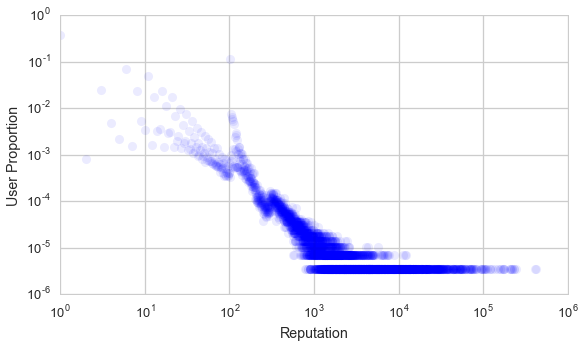

In [6]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',figsize=(9.1,5))

plt.loglog(df.Reputation, df.user_proportion,
          'bo', alpha=0.08)
plt.xlabel('Reputation')
plt.ylabel('User Proportion');

This plot shows that there are many users that have unique reputation scores.  By that I mean that the bottom row of points all have a probability of ~$5\times 10^{-6}$, which is one over the number of users.  That is, these are the reputation scores that only appear once in the dataset.  If we look at the horizontal span of this bottom cluster of points, we see that the first unique reputation value is just less than 1000.  Scanning to the right, the highest reputation value is somewhat less than one million.  

Another interesting aspect of this plot is the spike of reputation around 101.  This is due to the fact that users of other SE sites that have a reputation of more than 200 are automatically awarded 100 reputation points when they login to any other SE community.  

To get an estimate of the pdf, we need to bin this data into reputation bins.  This can be thought of as taking columns of this scatter plot and summing up the user proportion for that column bin.

## Bin Data
To catch the tails we bin the data using logarithmically increasing bins.  To do this we use <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html">`pandas.cut`</a>, which is super useful for doing operations on groups of binned data.  Basically `cut` let's you specify the boundaries of your bins and returns pandas groups of data for each bin.  For our purposes, we want to find the sum of each group.

In [7]:
cut_points = np.power(10, np.arange(0, 8, .1))
bins = pd.cut(df.Reputation, cut_points, right=False)
df_bin = df.groupby(bins).user_proportion.sum().reset_index()
df_bin['Reputation'] = cut_points[:-1]
df_bin.dropna(inplace=True)
df_bin.head()

,Reputation,user_proportion
0,1.000000,0.367720
3,1.995262,0.000806
4,2.511886,0.024190
6,3.981072,0.007016
7,5.011872,0.067914


## Plot & Fit
Now we can plot this data and fit it to a line.  A power law distribution has a pdf of the form 

$$f(x) = b x^{-a} = \tilde{b} e^{-\tilde{a}\ln(x)}.$$

Taking the $\log$ of the pdf, we get, 

$$\log(f(x)) = \tilde{b} - \tilde{a} \log{x},$$

which indicates that the log-log plot of the pdf follows a straight line (is affine).  Given this, one way to test whether a distribution follows a power law is to fit the pdf to a line.  We can do this with <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html">`numpy.polyfit`</a>.

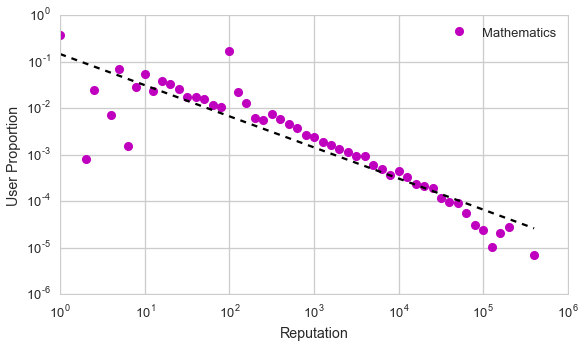

In [8]:
plt.loglog(df_bin.Reputation, df_bin.user_proportion,
           'mo', label='Mathematics')
p1 = np.poly1d(np.polyfit(np.log10(df_bin.Reputation), np.log10(df_bin.user_proportion), 1))
plt.loglog(df_bin.Reputation, np.power(10,p1(np.log10(df_bin.Reputation))), 'k--')
plt.legend()
plt.xlabel('Reputation')
plt.ylabel('User Proportion');

The linear fit looks pretty good.  Let's run the same experiment with reputation scores from Stack Overflow (SO) using <a href="https://data.stackexchange.com/stackoverflow/query/567522/number-of-users-with-reputation-n">this query</a>.  

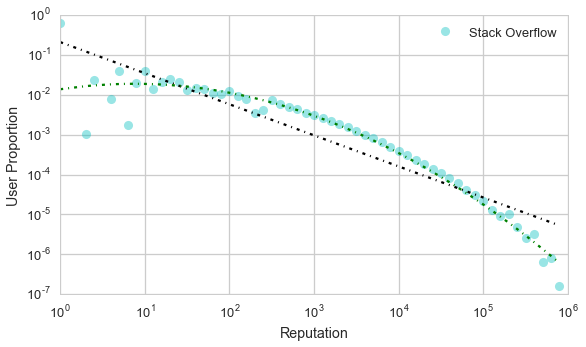

In [9]:
def plot_fit(df_bin_so, order, style):
    p = np.poly1d(
        np.polyfit(
            np.log10(df_bin_so.Reputation),
            np.log10(df_bin_so.user_proportion), order))
    plt.loglog(df_bin_so.Reputation,
               np.power(10, p(np.log10(df_bin_so.Reputation))), style)

    
def plot_and_fit(url, style, label, dofit=True):
    df = pd.read_csv(url, names=['Reputation', 'UserCount'], skiprows=1)
    
    df['user_proportion'] = df.UserCount / sum(df.UserCount)
    cut_points = np.power(10, np.arange(0, 8, .1))
    bins = pd.cut(df.Reputation, cut_points, right=False)
    df_bin_so = df.groupby(bins).user_proportion.sum().reset_index()
    df_bin_so['Reputation'] = cut_points[:-1]
    df_bin_so.dropna(inplace=True)
    
    plt.loglog(
        df_bin_so.Reputation,
        df_bin_so.user_proportion,
        style,
        alpha=.4,
        label=label)
    if dofit:
        plot_fit(df_bin_so, 1, 'k-.')
        plot_fit(df_bin_so, 2, 'g-.')
    plt.xlabel('Reputation')
    plt.ylabel('User Proportion')
    plt.legend()

plot_and_fit('https://data.stackexchange.com/stackoverflow/csv/715082', 'co',
             'Stack Overflow')

The SO reputation pdf looks much less linear, but fits a quadratic line really well.  This implies that the distribution is of the form 

$$f(x) = \tilde{b} e^{-\tilde{a}\ln^2(x)}.$$

This has a less heavy tail than a power law distribution.  If we overlay the two distributions, they are remarkably similar.  The difference is just that there are 50x fewer Math users.


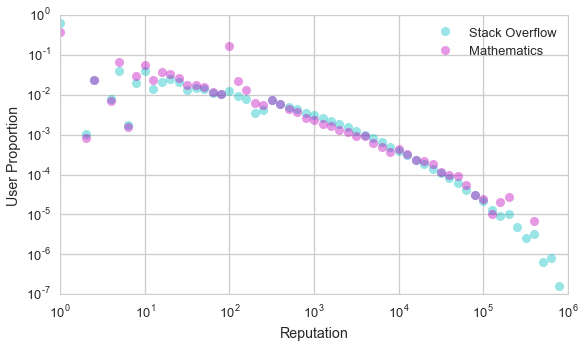

In [10]:
plot_and_fit('https://data.stackexchange.com/stackoverflow/csv/715082', 'co',
             'Stack Overflow', False)
plot_and_fit('http://data.stackexchange.com/math/csv/715124', 'mo',
             'Mathematics', False)

## Conclusion

I am surprised that the distributions are so similar.  Since SO has a more diverse audience and people with a wider variety of skills can get reputation, I would have suspected that the SO reputation would differ more significantly from the SE.Math reputation distribution.

As to whether the distribution follows the power law, it is hard to say, but it appears to not quite have a heavy enough tail.  On the other hand, the fit is good until the very tail, so it is hard to say if the drop off at the tail is an artifact of not having enough samples. 